# Feature Selection Using Wrapper Methods

### Project Brief

**Objective:** In this project, I will perform feature selection using three different wrapper methods on a dataset obtained from a survey about eating habits and weight. The goal is to identify a smaller subset of features that can accurately predict whether a survey respondent is obese or not.

Data source: [UCI Machine Learning Repository - Estimation of obesity levels](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition)

### Tasks Overview

Here's a breakdown of the tasks I'll be performing using Python and various packages:

1. **Data Loading and Inspection**: I'll load the dataset and inspect its structure using `pandas`. This will help me understand the available features and the target variable.

2. **Logistic Regression Model**: I'll create a logistic regression model using `LogisticRegression` from `sklearn` to establish a baseline accuracy for comparison.

3. **Sequential Forward Selection (SFS)**: I'll implement SFS using the `SequentialFeatureSelector` class from `mlxtend` to select a subset of features that maximizes accuracy. I'll then evaluate the model's accuracy on this reduced feature set.

4. **Sequential Backward Selection (SBS)**: I'll implement SBS using the `SequentialFeatureSelector` class from `mlxtend` to select another subset of features that maximizes accuracy. Again, I'll evaluate the model's accuracy on this subset.

5. **Recursive Feature Elimination (RFE)**: I'll standardize the data and apply RFE using `RFE` from `sklearn` to select a subset of features. I'll also evaluate the model's accuracy on this reduced feature set.

6. **Visualizing Results**: I'll visualize the results of SFS and SBS by plotting the model accuracy as a function of the number of features used.

Let's jump into it!

-----

## Import libraries

In [75]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder

## Evaluating a Logistic Regression Model

The data set `obesity` contains 18 predictor variables. Here's a brief description of them.

* `Gender` is `1` if a respondent is male and `0` if a respondent is female.
* `Age` is a respondent's age in years.
* `family_history_with_overweight` is `1` if a respondent has family member who is or was overweight, `0` if not.
* `FAVC` is `1` if a respondent eats high caloric food frequently, `0` if not.
* `FCVC` is `1` if a respondent usually eats vegetables in their meals, `0` if not.
* `NCP` represents how many main meals a respondent has daily (`0` for 1-2 meals, `1` for 3 meals, and `2` for more than 3 meals).
* `CAEC` represents how much food a respondent eats between meals on a scale of `0` to `3`.
* `SMOKE` is `1` if a respondent smokes, `0` if not.
* `CH2O` represents how much water a respondent drinks on a scale of `0` to `2`.
* `SCC` is `1` if a respondent monitors their caloric intake, `0` if not.
* `FAF` represents how much physical activity a respondent does on a scale of `0` to `3`.
* `TUE` represents how much time a respondent spends looking at devices with screens on a scale of `0` to `2`.
* `CALC` represents how often a respondent drinks alcohol on a scale of `0` to `3`.
* `MTRANS`, with values `Automobile`, `Bike`, `Motorbike`, `Public_Transportation`, and `Walking` indicate a respondent's primary mode of transportation. Their primary mode of transportation is indicated by a `1` and the other columns will contain a `0`.

The outcome variable, `NObeyesdad`, is a `1` if a patient is obese and a `0` if not.

In [76]:
# Load the data
obesity = pd.read_csv("dataset/obesity.csv")

# Inspect the data
obesity.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


In [77]:
# Convert the "MTRANS" column to dummies
X_dummies = pd.get_dummies(obesity["MTRANS"])

# Add the dummy variables back into the original DataFrame
obesity = pd.concat([obesity, X_dummies], axis=1)

# Drop the original "MTRANS" column
obesity.drop(columns=["MTRANS"], inplace=True)


In [98]:
obesity.describe()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.419043,2.685628,2.008011,1.010298,0.657866
std,6.345968,0.093305,26.191172,0.533927,0.778039,0.612953,0.850592,0.608927
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,19.947192,1.630000,65.473343,2.000000,2.658738,1.584812,0.124505,0.000000
50%,22.777890,1.700499,83.000000,2.385502,3.000000,2.000000,1.000000,0.625350
75%,26.000000,1.768464,107.430682,3.000000,3.000000,2.477420,1.666678,1.000000
max,61.000000,1.980000,173.000000,3.000000,4.000000,3.000000,3.000000,2.000000


### Split the data into `X` and `y`

In [78]:
# Split the data into predictor variables and an outcome variable
X = obesity.drop(["NObeyesdad"], axis=1)
y = obesity.NObeyesdad

# Get feature names
features = X.columns

### Identify all categorical variables

In [79]:
# Identify categorical columns (object type)
categorical_columns = [column for column, dtype in X.dtypes.items() if dtype == 'object']

# Remove "NObeyesdad" from the list if it exists
if "NObeyesdad" in categorical_columns:
    categorical_columns.remove("NObeyesdad")

# 'categorical_columns' now contains the names of other categorical columns
print(categorical_columns)


['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC']


### Encode categoricals

In [80]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Create a new DataFrame to store the encoded categorical variables
X_enc = X.copy()

# Loop through each categorical column and encode it
for column in categorical_columns:
    X_enc[column] = le.fit_transform(X[column])


### Standardize

In [81]:
# Standardize the data
scaler = StandardScaler()
X_enc_scaled = scaler.fit_transform(X_enc)

### Logistic regression model

In [82]:
# Create a logistic regression model
lr = LogisticRegression(max_iter=1000)

### Fit the model

In [83]:
# Fit the logistic regression model
lr.fit(X_enc_scaled, y)

LogisticRegression(max_iter=1000)

### Model accuracy

In [84]:
# Print the accuracy of the model
print(lr.score(X_enc_scaled,y))

0.9052581714827096


## Feature Selection

### Sequential Forward Selection

In [85]:
# Create a sequential forward selection model
sfs = SFS(lr, 
          k_features=6, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=0)

### Fit the model

In [86]:
# Fit the sequential forward selection model to X and y
sfs.fit(X_enc_scaled, y)

# Inspect the results of sequential forward selection
print(sfs.subsets_[6])

{'feature_idx': (0, 2, 3, 6, 16, 17), 'cv_scores': array([0.92325912]), 'avg_score': 0.9232591189009948, 'feature_names': ('0', '2', '3', '6', '16', '17')}


### Chosen features and model accuracy

In [87]:
# Indexes selected by sequential backward selection
selected_indexes = [int(idx) for idx in sfs.subsets_[6]['feature_names']]

# Get the corresponding column names
selected_column_names = [features[idx] for idx in selected_indexes]
print(selected_column_names)

# Print the model accuracy after doing sequential forward selection
print(sfs.subsets_[6]['avg_score'])

['Gender', 'Height', 'Weight', 'FCVC', 'Bike', 'Motorbike']
0.9232591189009948


**Summary:** Compared to model’s accuracy (i.e., .905) on all available features, the accuracy of the model using sequential forward selection for 6 features (i.e., .923) marginally increased.

### Visualize model accuracy

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


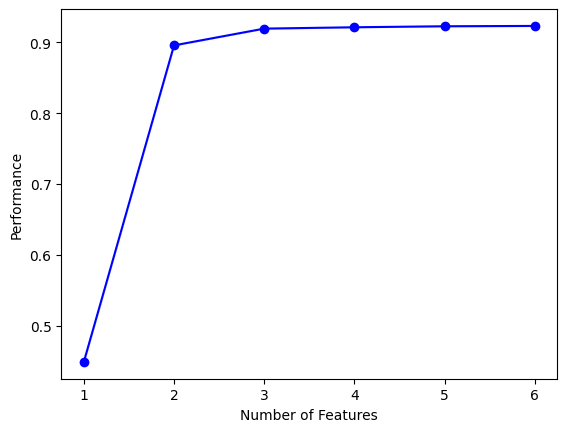

In [88]:
# Plot the model accuracy as a function of the number of features used
plot_sfs(sfs.get_metric_dict())
plt.show()

### Sequential Backward Selection

In [89]:
# Create a sequential backward selection model
sbs = SFS(lr, 
          k_features=7, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=0)

### Fit the model

In [90]:
# Fit the sequential backward selection model to X and y
sbs.fit(X_enc_scaled, y)

# Inspect the results of sequential backward selection
print(sbs.subsets_[7])

{'feature_idx': (0, 2, 3, 4, 5, 11, 14), 'cv_scores': array([0.91662719]), 'avg_score': 0.9166271909047845, 'feature_names': ('0', '2', '3', '4', '5', '11', '14')}


### Chosen features and model accuracy

In [91]:
# Indexes selected by sequential backward selection
selected_indexes = [int(idx) for idx in sbs.subsets_[7]['feature_names']]

# Get the corresponding column names
selected_column_names = [features[idx] for idx in selected_indexes]
print(selected_column_names)

# Print the model accuracy after doing sequential backward selection
print(sbs.subsets_[7]['avg_score'])

['Gender', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'SCC', 'CALC']
0.9166271909047845


**Summary:** Compared to model’s accuracy (i.e., .905) on all available features and the accuracy of the model using sequential forward selection (i.e., 923), the accuracy of the model using sequential backward selection for 7 features (i.e., .917) marginally decreased.

### Visualize model accuracy

C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Marc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


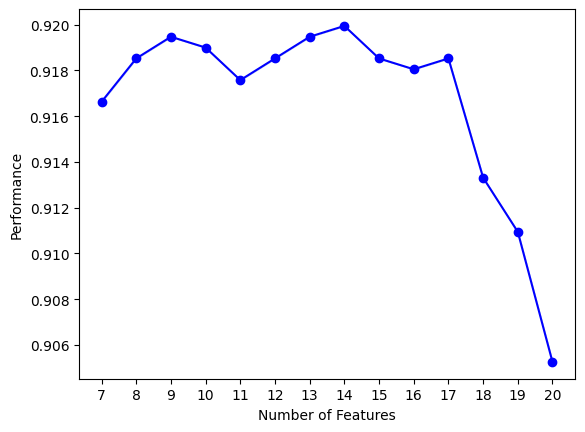

In [92]:
# Plot the model accuracy as a function of the number of features used
plot_sfs(sbs.get_metric_dict())
plt.show()

### Recursive Feature Elimination

In [93]:
# Standardize the data
X = pd.DataFrame(StandardScaler().fit_transform(X_enc_scaled))

### Create and Fit the model

In [94]:
# Create a recursive feature elimination model
rfe = RFE(estimator=lr, n_features_to_select=6)

#   Fit the recursive feature elimination model to X and y
rfe.fit(X_enc_scaled, y)

RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=6)

### Inspect chosen features

In [95]:
# See which features recursive feature elimination chose
rfe_features = [f for (f, support) in zip(features, rfe.support_) if support]
print(rfe_features)

['Gender', 'Age', 'Height', 'Weight', 'FCVC', 'Public_Transportation']


### Model accuracy

In [96]:
# Print the model accuracy after doing recursive feature elimination
print(rfe.score(X_enc_scaled, y))

0.9090478446234013


**Summary:** Compared to model’s accuracy (i.e., .905) on all available features, the accuracy of the model using sequential forward selection (i.e., 923) or sequential backward selection for 7 features (i.e., .917), the accuracy of the model using recursive feature elimination (i.e., .909) marginally decreased. <br>   
Leads to following feature list:  
- 'Gender', 
- 'Height', 
- 'Weight', 
- 'FCVC', 
- 'Bike', 
- 'Motorbike'